# Portfolio Optimization
-------------------------
## Optimization based on Markowitz's Efficient Frontier and CvaR 

In [60]:
'''
documentation: https://pyportfolioopt.readthedocs.io/en/stable/

'''
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

%matplotlib inline

In [61]:
# Read in price (Adj Close) data from csv file (Adj Close prices pulled from the yahoo_historical.ipynb)
stock_prices = pd.read_csv("Resources/multi_stock_prices.csv", parse_dates=True, index_col="Date")
stock_prices.tail()

,KOIN,LQD,SPY,VNQ
Date,,,,
2021-03-11,40.338001,130.210007,392.245300,90.110001
2021-03-12,39.995998,128.710007,392.773560,91.620003
2021-03-15,40.200001,129.149994,395.115906,92.980003
2021-03-16,40.389999,129.059998,394.617523,92.599998
2021-03-17,40.516998,129.179993,395.963135,92.680000


In [62]:
from pypfopt.risk_models import CovarianceShrinkage

# Calculate expected returns (CAPM based) and covariance (Ledoid Wolf covariance shrinkage)
mu = expected_returns.capm_return(stock_prices)
S = CovarianceShrinkage(stock_prices).ledoit_wolf()

# Print expected returns
mu

KOIN    0.148805
LQD     0.049154
SPY     0.151468
VNQ     0.163195
Name: mkt, dtype: float64

In [63]:
# Specify allocation constraints for each sector or individual security

sector_mapper = {
            "KOIN": "crypto",
            "LQD": "bonds",
            "SPY": "large_cap",
            "VNQ": "real_estate"
        }

sector_lower = {
            "bonds": 0.3, # min 30% bonds
            "large_cap": 0.40 # min 40% equities
            } 

sector_upper = {
            "crypto": 0.05, # less than 5% crypto
            "real_estate": 0.10 # less than 10% real estate
            }

In [64]:
# Construct Efficient Frontier optimization model based on the maximum Sharpe ratio (alternatively we can optimize by minimum volatility which is a good option too - by entering w=ef.min_volatility()) and specify gamma to minimize zero weights (higher gamma means less zero weights) and sector allocation constraints

from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
w = ef.max_sharpe()
weights = ef.clean_weights()
print(ef.clean_weights())

OrderedDict([('KOIN', 0.05), ('LQD', 0.3), ('SPY', 0.55), ('VNQ', 0.1)])
/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


<AxesSubplot:title={'center':'Asset Allocation'}>

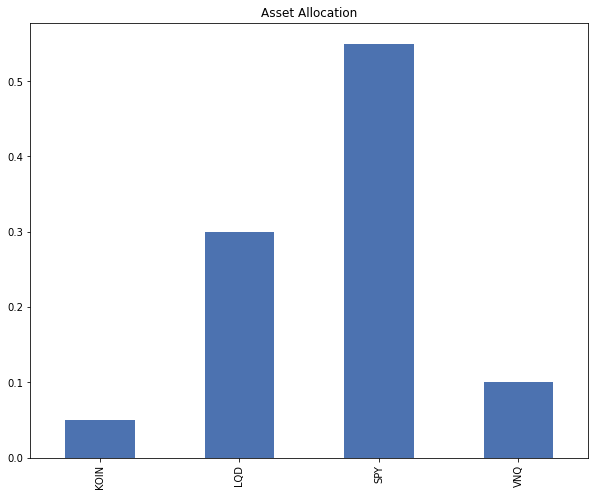

In [65]:
# Plot asset allocation based on Efficient Frontier model
pd.Series(weights).plot.bar(figsize=(10, 8), ylabel='', title='Asset Allocation')

In [66]:
# Evaluate portfolio performance
ef.portfolio_performance(verbose=True)

Expected annual return: 12.2%
Annual volatility: 16.9%
Sharpe Ratio: 0.60


(0.1218133743612702, 0.16850511534183893, 0.6042153328979115)

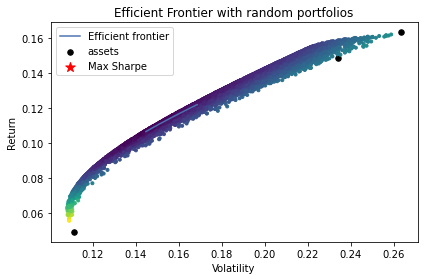

In [67]:
# Plot Efficient Frontier based on random portfolios and  individual assets
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

## Portfolio Optimization with CVaR
-------------------------------------
### Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has

In [68]:
from pypfopt import EfficientCVaR

# Calculate expected returns (mu) and covariance (risk)
mu = expected_returns.capm_return(stock_prices)
S = CovarianceShrinkage(stock_prices).ledoit_wolf()

In [69]:
# Portfolio optimization based on Efficient Frontier and maximum Sharpe ratio

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.max_sharpe()
weights_arr = ef.weights
ef.portfolio_performance(verbose=True)
print(f"weights = {weights_arr}")

Expected annual return: 12.2%
Annual volatility: 16.9%
Sharpe Ratio: 0.60
weights = [0.05 0.3  0.55 0.1 ]
/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


In [70]:
# Calculate stock returns from historical stock prices
returns = expected_returns.returns_from_prices(stock_prices).dropna()
returns

,KOIN,LQD,SPY,VNQ
Date,,,,
2018-02-02,-0.022285,-0.005116,-0.021770,-0.008490
2018-02-05,-0.032325,0.000590,-0.041823,-0.029710
2018-02-06,0.019700,-0.002022,0.019703,0.000134
2018-02-07,-0.006720,-0.002786,-0.005425,-0.004278
2018-02-08,-0.040169,-0.004318,-0.037509,-0.028733
...,...,...,...,...
2021-03-11,0.022665,0.000615,0.010139,0.011676
2021-03-12,-0.008478,-0.011520,0.001347,0.016757
2021-03-15,0.005101,0.003418,0.005964,0.014844


<AxesSubplot:>

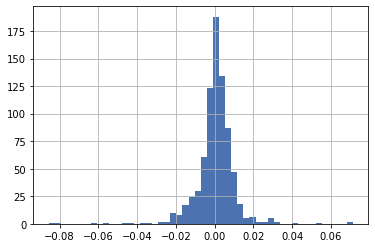

In [71]:
# Calculate portfolio returns and plot probability distribution (normal distribution)
portfolio_rets = pd.DataFrame(returns * weights_arr).sum(axis=1)
portfolio_rets.hist(bins=50)

In [72]:
# Calculate 95% CVaR for the max-sharpe portfolio
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

print(f"The average loss on the worst 5% of days will be {cvar :.4f}")

VaR: -1.49%
CVaR: -2.65%
The average loss on the worst 5% of days will be -0.0265


In [73]:
# Construct a portfolio with the minimum CVar, print performance and weights

ec = EfficientCVaR(mu, returns)
ec.add_objective(objective_functions.L2_reg, gamma=0.1)
ec.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ec.min_cvar()
ec.portfolio_performance(verbose=True)
ec.weights

# We have lowered CVaR by 0.40% (from 2.65% to 2.25%) at the expense of 1.60% return (from 12.2% to 10.6%)

Expected annual return: 10.6%
Conditional Value at Risk: 2.25%


array([0.04999885, 0.45000257, 0.39999901, 0.09999958])

In [74]:
# Another option is to maximize return for the given CvaR (set a % CvaR that is acceptable, however make sure you understand what CvaR means). Print performance and weights

ec = EfficientCVaR(mu, returns)
#ec.add_objective(objective_functions.L2_reg, gamma=0.1) # solver 'OSQP failing with this constraint (purpose to minimize zero weights)
ec.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ec.efficient_risk(target_cvar=0.0230)
ec.portfolio_performance(verbose=True)
ec.weights

Expected annual return: 10.8%
Conditional Value at Risk: 2.30%


array([0.05      , 0.43022867, 0.41977133, 0.1       ])

In [75]:
# original portfolio performance and weights based on max Sharpe ratio
ef.portfolio_performance(verbose=True)
ef.weights

Expected annual return: 12.2%
Annual volatility: 16.9%
Sharpe Ratio: 0.60


array([0.05, 0.3 , 0.55, 0.1 ])

In [76]:
# In this case we have lowered the portfolio return by 1.40% (from 12.2% to 10.8%) by accepting CvAR of 2.3% (from 2.65%), which means that the average loss on the worst 5% of days will be 2.3% of the portfoio. On the $100,000 portfolio value one day loss could be $2,300.00 (as opposed to $2,600.00).